# COGS 118C Final Project

## Setup

In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt

### Read Data

In [2]:
sub1_set = 'data/subject1/sub-01_task-songfamiliarity_eeg.set'

# Read the raw data
raw = mne.io.read_raw_eeglab(sub1_set, preload=True)

# Print the head of the data
print(raw.info)
print(raw[:5][0])

Reading /Users/gregoryweber/Documents/cogs-118c-song-familiarity/data/subject1/sub-01_task-songfamiliarity_eeg.fdt
Reading 0 ... 1807099  =      0.000 ...  1807.099 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC5, FC1, FCz, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>
[[ 6.26690507e-07 -1.36414266e-06 -2.39269257e-06 ...  7.34802551e-05
   7.60795364e-05  7.84163055e-05]
 [ 4.47712212e-05  4.13577881e-05  4.45301132e-05 ... -2.66145658e-06
  -3.80891657e-06 -1.41250744e-07]
 [ 3.79548416e-05  3.37484283e-05  3.93421669e-05 ...  6.94403744e-06
   1.17275648e-05  1.49056187e-05]
 [ 3.40858345e-05  3.10366974e-05  3.39455452e-05 ...  2.52606812e-05
   2.85402775e-05  3.17569542e-05]
 [ 7.62951493e-07 -2.44054031e-06 -1.06173754e-07 ...  2.27950230e-05
   2.10377178e-05  2.03138027e-05]]


### Show Time Series

In [4]:
raw.plot(duration=10, n_channels=raw.info['nchan'], scalings='auto')

Using pyopengl with version 3.1.6


<mne_qt_browser._pg_figure.MNEQtBrowser(0x158dcb530) at 0x35174b5c0>

Channels marked as bad:
none


/Users/gregoryweber/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


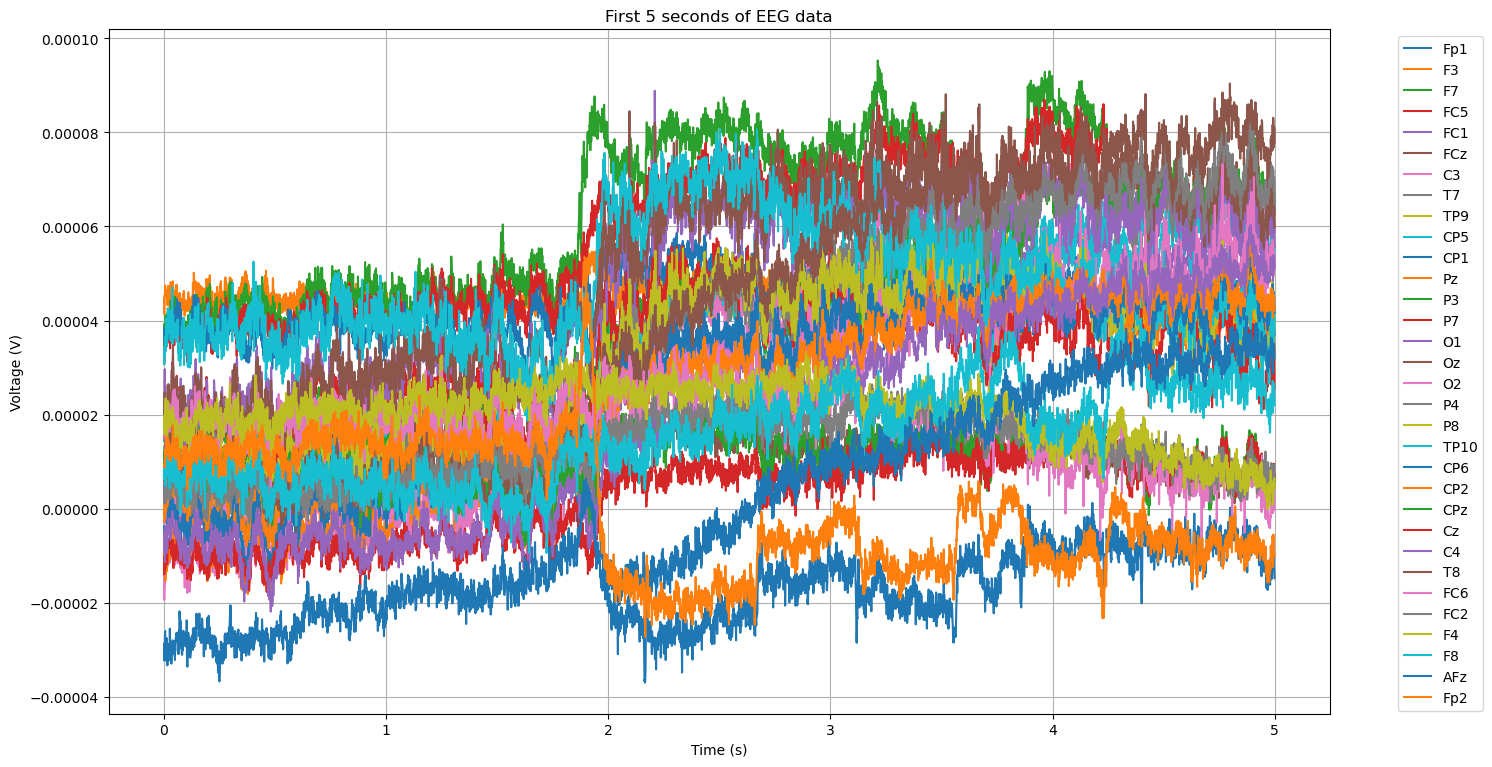

In [8]:
data, times = raw[:, :5000]  # Get first 5 seconds (5000 samples at 1000Hz)
plt.figure(figsize=(15, 8))
for i in range(len(raw.ch_names)):
  plt.plot(times, data[i], label=raw.ch_names[i])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First 5 seconds of EEG data')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

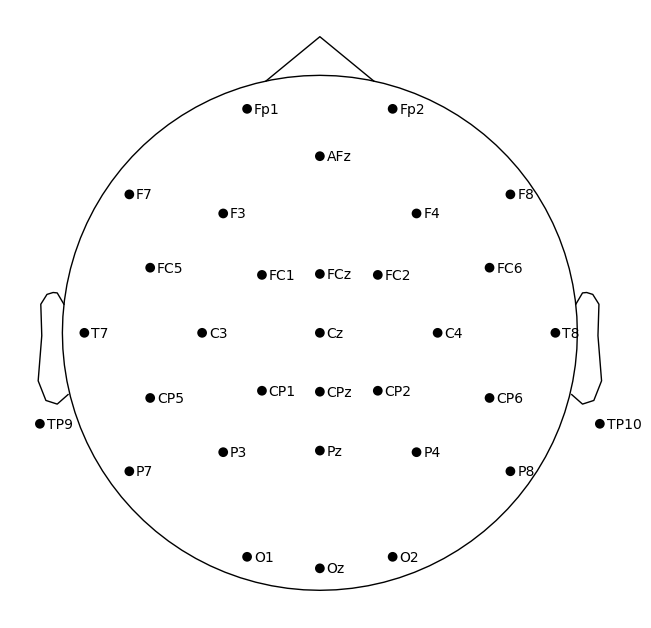


Sensor names:
['Fp1', 'F3', 'F7', 'FC5', 'FC1', 'FCz', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'CPz', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AFz', 'Fp2']


In [9]:
# Plot electrode positions on a head
a = raw.plot_sensors(show_names=True)
print("\nSensor names:")
print(raw.ch_names)

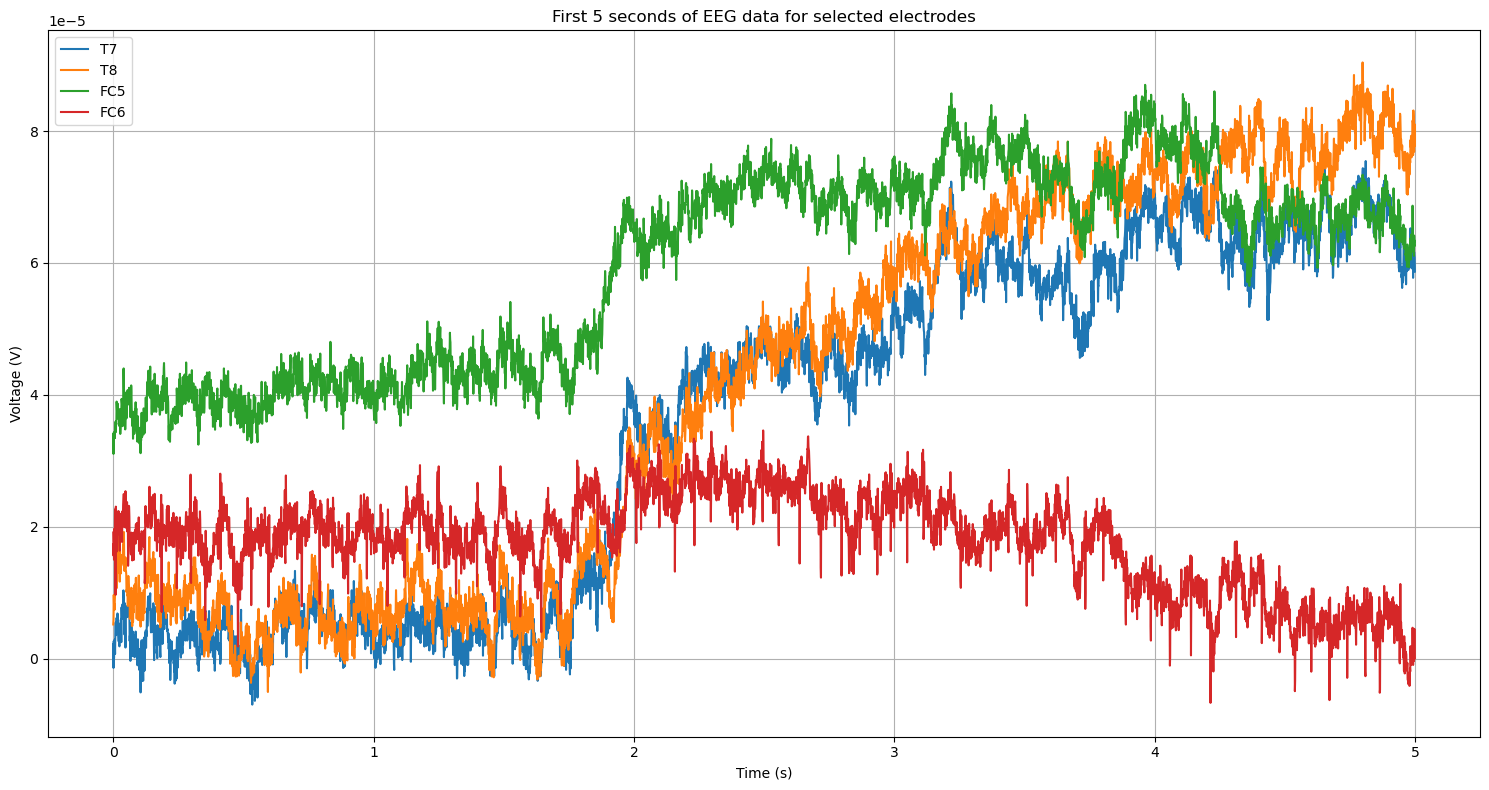

In [10]:
# Graph time series for T7, T8, FC5, and FC6 electrodes, as these are most relevant

# Get the indices of the electrodes
T7_idx = raw.ch_names.index('T7')
T8_idx = raw.ch_names.index('T8')
FC5_idx = raw.ch_names.index('FC5')
FC6_idx = raw.ch_names.index('FC6')

# Get first 5 seconds of data for selected electrodes
data, times = raw[[T7_idx, T8_idx, FC5_idx, FC6_idx], :5000]

plt.figure(figsize=(15, 8))
plt.plot(times, data[0], label='T7')
plt.plot(times, data[1], label='T8')
plt.plot(times, data[2], label='FC5')
plt.plot(times, data[3], label='FC6')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First 5 seconds of EEG data for selected electrodes')
plt.grid(True)
plt.legend()
plt.tight_layout()

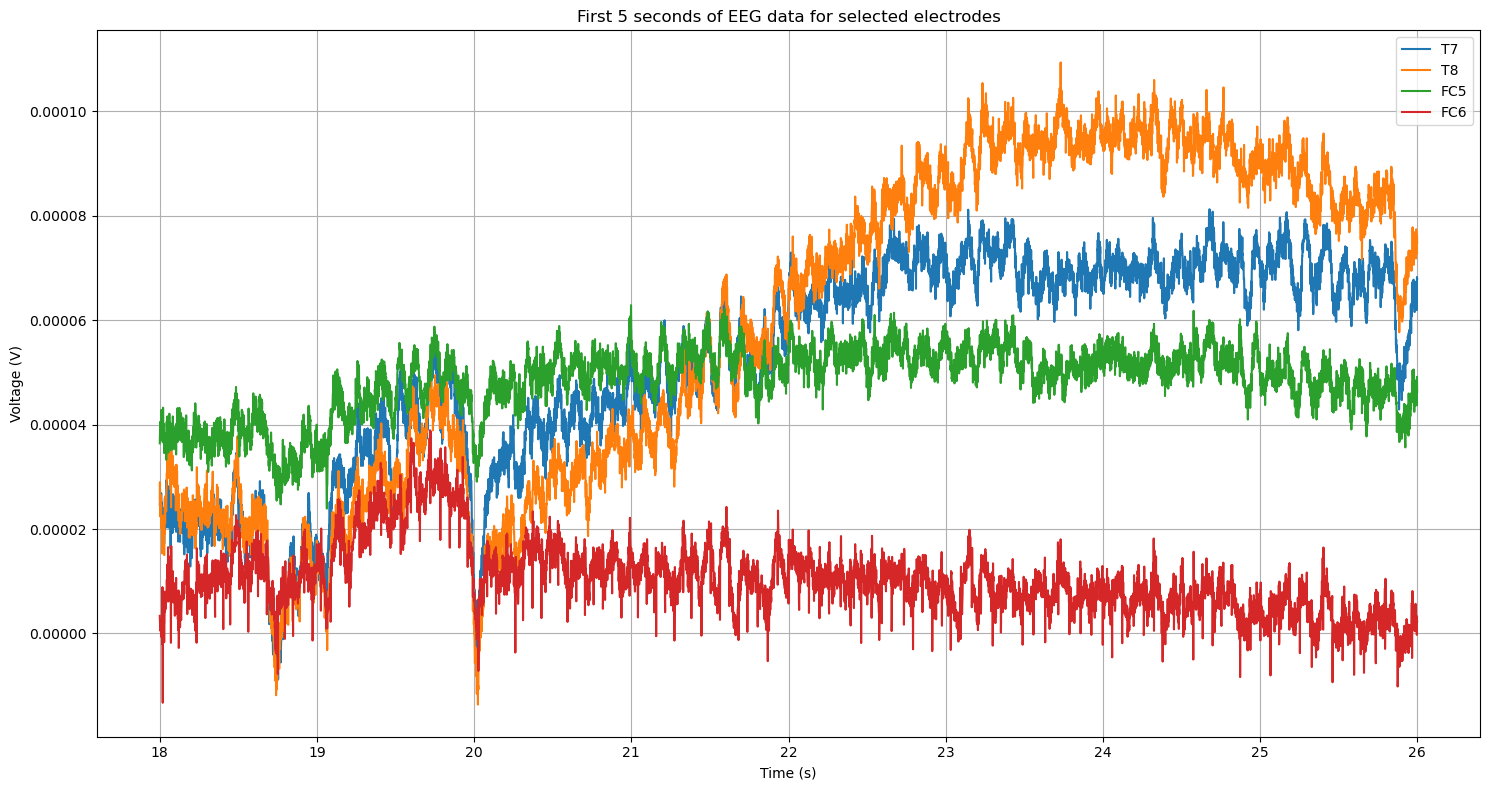

In [ ]:
# Look at first sample played from 18 seconds to 26 seconds

T7_idx = raw.ch_names.index('T7')
T8_idx = raw.ch_names.index('T8')
FC5_idx = raw.ch_names.index('FC5')
FC6_idx = raw.ch_names.index('FC6')

data, times = raw[[T7_idx, T8_idx, FC5_idx, FC6_idx], 18000:26000]

plt.figure(figsize=(15, 8))
plt.plot(times, data[0], label='T7')
plt.plot(times, data[1], label='T8')
plt.plot(times, data[2], label='FC5')
plt.plot(times, data[3], label='FC6')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First Sample with Selected Electrodes')
plt.grid(True)
plt.legend()
plt.tight_layout()